In [3]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
import os
# fastica, picard, infomax. Picard maybe better

In [4]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 0.5
    highcut = 38
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # Define the filter parameters
    lowcut = 48
    highcut = 52
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='bandstop')

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    
    return df_filt1

In [5]:
filename_list = [
'EEGdata-2024-144--14-24-41',
'EEGdata-2024-144--14-47-17',
'EEGdata-2024-144--14-56-37',
'EEGdata-2024-144--15-28-30',
'EEGdata-2024-144--15-54-35',
'EEGdata-2024-148--14-42-07',
'EEGdata-2024-148--14-48-17',
'EEGdata-2024-148--14-55-39',
'EEGdata-2024-149--15-20-21',
'EEGdata-2024-149--15-35-40',
'EEGdata-2024-149--15-45-38',
'EEGdata-2024-149--15-57-42',
'EEGdata-2024-149--16-41-44',
'EEGdata-2024-150--14-48-32',
'EEGdata-2024-150--14-55-28',
'EEGdata-2024-150--15-01-30',
'EEGdata-2024-150--15-07-57',
'EEGdata-2024-150--15-14-53',
'EEGdata-2024-150--15-30-23',
'EEGdata-2024-150--15-36-40',
'EEGdata-2024-150--15-42-38',
'EEGdata-2024-156--14-35-07',
'EEGdata-2024-156--14-42-54',
'EEGdata-2024-156--14-51-06',
'EEGdata-2024-156--14-58-57',
'EEGdata-2024-156--15-06-57',
'EEGdata-2024-156--15-21-50',
'EEGdata-2024-156--15-27-22',
'EEGdata-2024-162--11-15-01',
'EEGdata-2024-162--11-20-53',
'EEGdata-2024-162--11-28-38',
'EEGdata-2024-162--11-35-23']

In [8]:
def ICA_filtering(file_name1):
    # Select file from measurement
    # Change next to lines if needed
    path = "C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/"
    filename = file_name1

    df = pd.read_csv(path+filename + ".csv", sep=",")
    end = df.shape[0] # Remove 5 samples buffer at the end
    fs = 250
    df = df.iloc[:end, :8] # Select 72000 samples from 8 channels

    #Apply the filters and DC component removal
    df = filter(df)

    # Constants
    num_components = 8
    allOutputs = df

    channels = df.T

    # create mne_info object
    ch_names =        ['Fz', 
                'C3',  'Cz',  'C4', 
                    'Pz', 
                'PO7', 'Oz',  'PO8']

    ch_type = ['eeg' for i in range(8)]
    mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

    #create mne.raw object
    raw = mne.io.RawArray(channels, mne_info)
    raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

    #actual code
    raw.filter(0.5, 38)

    # ICA model
    ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
    #ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
    ica.fit(raw) # fit the model on the data

    bad_channels_l = []
    i = 0

    # Cycle through exclude indices from 0 to 7
    for exclude_index in range(8):
        dif_l1 = []
        # Change the indices which needs to be removed based on the plots and bad channels
        ica.exclude = [exclude_index]  # indices chosen based on various plots above

        # ica.apply() changes the Raw object in-place, so let's make a copy first:
        reconst_raw = raw.copy()
        ica.apply(reconst_raw)

        # Transpose to recreate the original shape
        raw_array = raw[:][0].T
        reconst_raw_array = reconst_raw[:][0].T

        for channel in range(8):
            # assign raw and reconstructed signal to variables
            signal1 = raw_array[:,channel]
            signal2 = reconst_raw_array[:,channel]

            # calculate the minimum and maximum of both signals to determine peaks
            max1 = np.max(signal1)
            max2 = np.max(signal2)
            min1 = np.min(signal1)
            min2 = np.min(signal2)

            mean1 = np.mean(signal1)

            # Calculate the difference betweeen man and min of both signals
            dif1 = max1 - min1
            dif2 = max2 - min2

            # Append to list
            dif_l1.append(dif1 - dif2)

        bad_channels = [i for i, value in enumerate(dif_l1) if value > 50]
        if len(bad_channels) > 0:
            bad_channels_l.append(i)
        
        # # plot the original and ICA filtered signal
        # x1 = np.linspace(0, end/fs, end, endpoint=True)

        # fig, axs = plt.subplots(8, figsize=(10 , 5))
        # fig.suptitle(f'EEG signals channel {exclude_index} excluded')
        # for i in range(8):
        #     # axs[i].plot(x1[1000:],raw_array[1000:,i])
        #     # axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
        #     axs[i].plot(x1[:],raw_array[:,i])
        #     axs[i].plot(x1[:],reconst_raw_array[:,i])
        #     axs[i].set_xlabel('Time (seconds)')
        #     axs[i].set_ylabel(f'Channel {i+1}')

        # plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
        # plt.show()

        i += 1
        
    # Change the indices which needs to be removed based on the plots and bad channels
    ica.exclude = bad_channels_l  # indices chosen based on various plots above

    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)

    # Transpose to recreate the original shape
    raw_array = raw[:][0].T
    reconst_raw_array = reconst_raw[:][0].T

    # plot the original and ICA filtered signal
    x1 = np.linspace(0, end/fs, end, endpoint=True)

    fig, axs = plt.subplots(8, figsize=(10 , 5))
    fig.suptitle('EEG signals')
    for i in range(8):
        axs[i].plot(x1[1000:],raw_array[1000:,i])
        axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
        # axs[i].plot(x1[:],raw_array[:,i])
        # axs[i].plot(x1[:],reconst_raw_array[:,i])
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel(f'Channel {i+1}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

    # Convert ICA signal to csv file and add columns which were removed before ICA
    ICA_data = pd.DataFrame(reconst_raw_array)

    # Add columns that were removed
    df = pd.read_csv(path+filename + ".csv", sep=",")
    columns_add = df[['Counter', 'Validation', 'Label']] # select the last three columns to be added

    # Rename the columns of df2 to correspond to the first 8 columns of df1
    ICA_data.columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

    # Adding the last three columns to ICA_data
    ICA_data = pd.concat([ICA_data, columns_add], axis=1)

    # Convert to csv
    ICA_data.to_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/" +filename + "_ICA.csv", index = False)

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


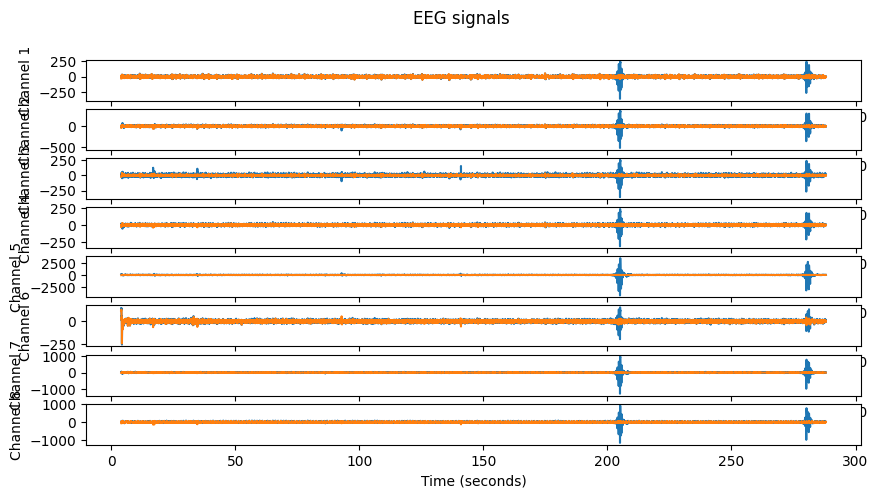

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


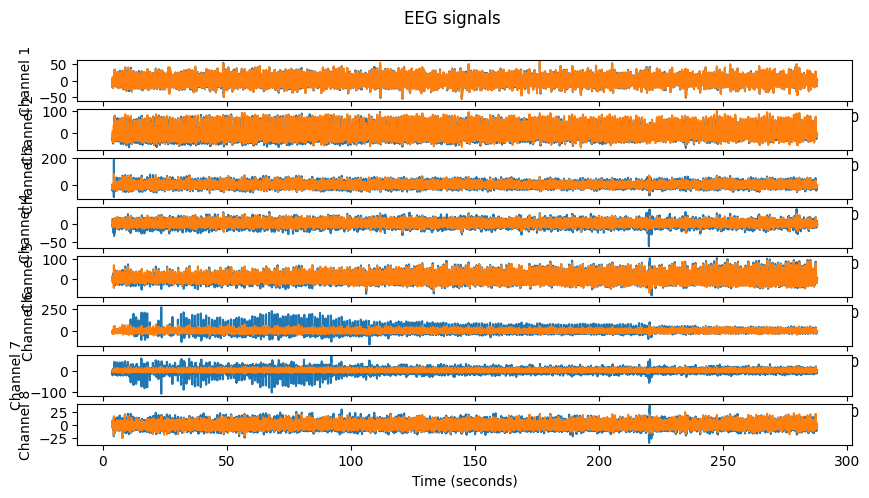

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 5.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


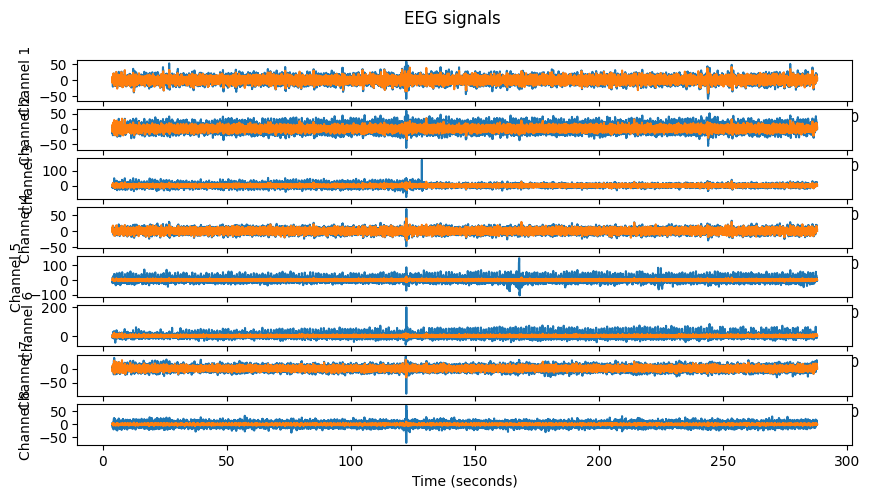

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


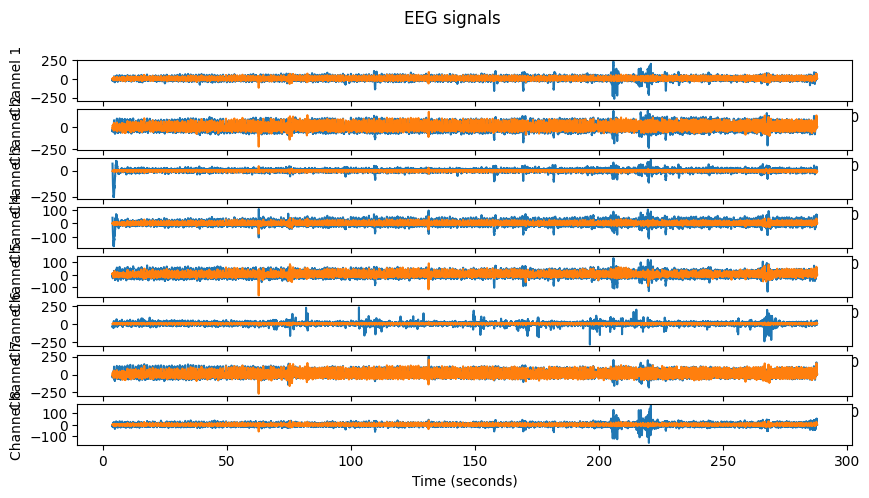

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


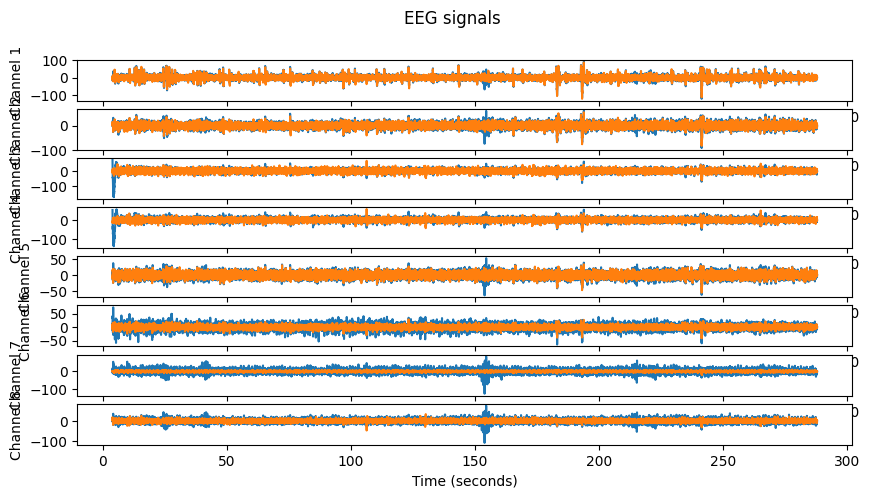

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


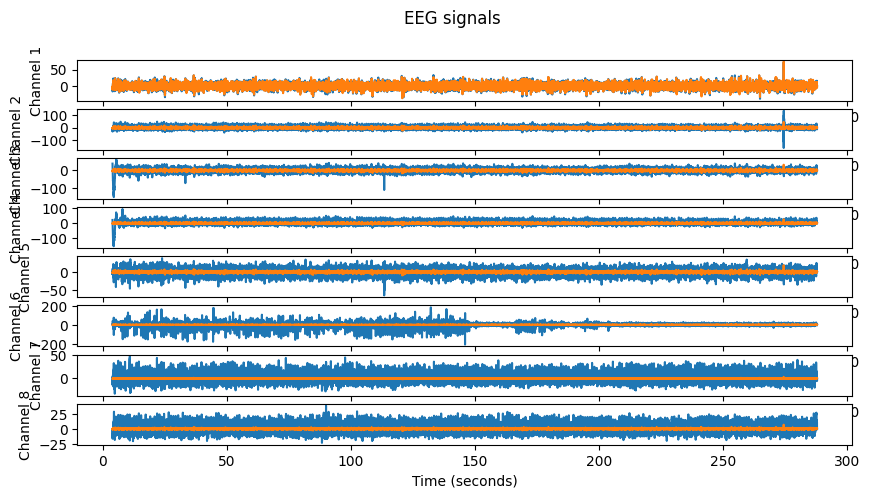

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


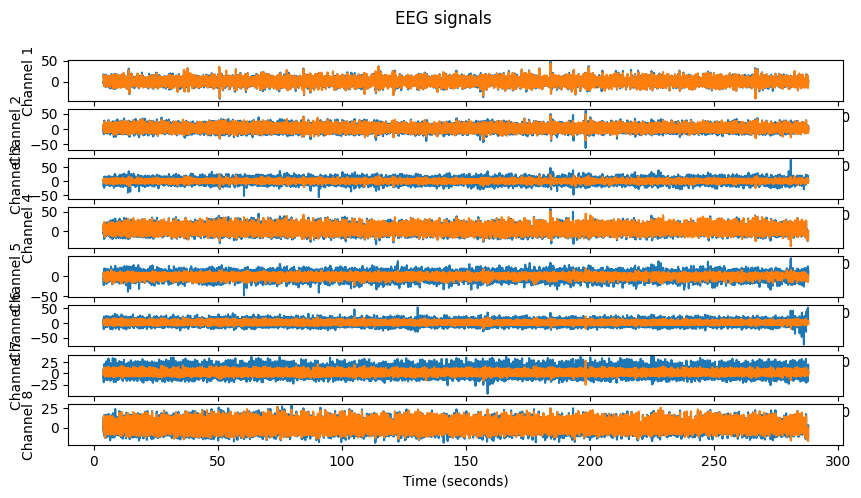

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


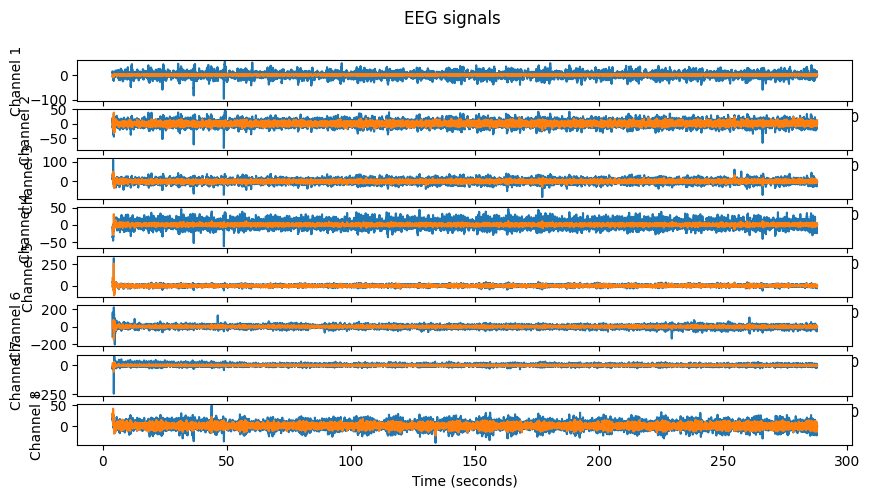

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


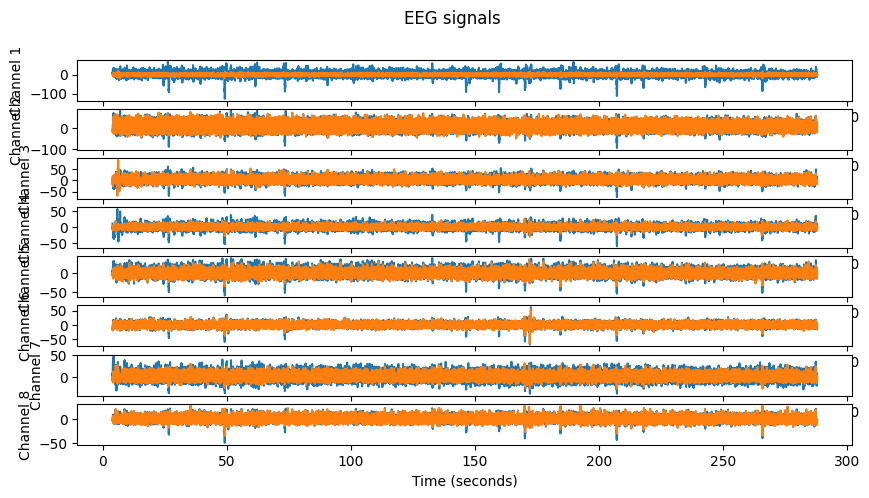

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


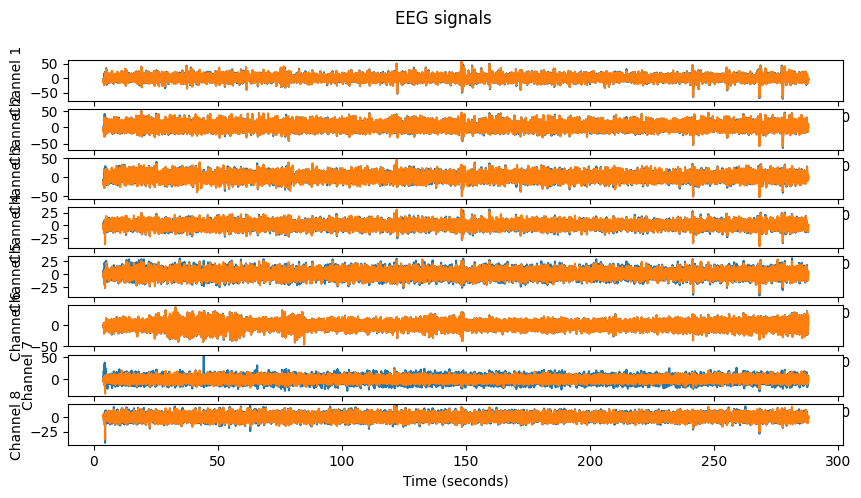

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


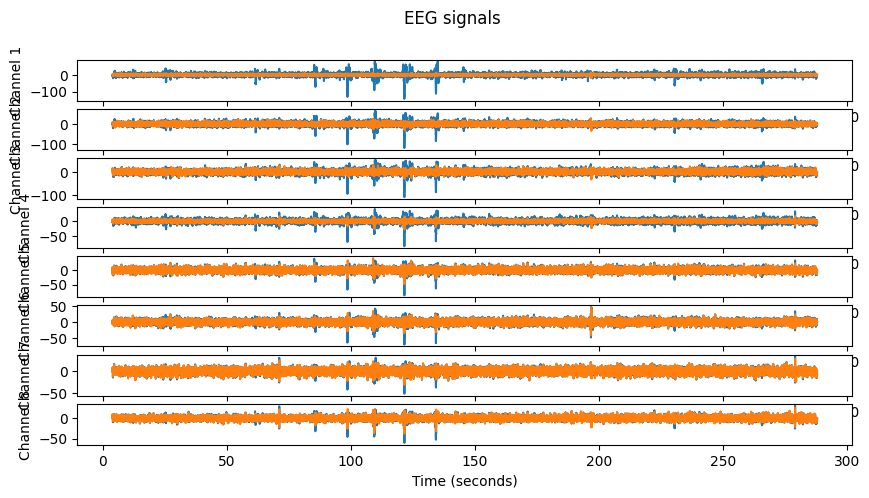

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


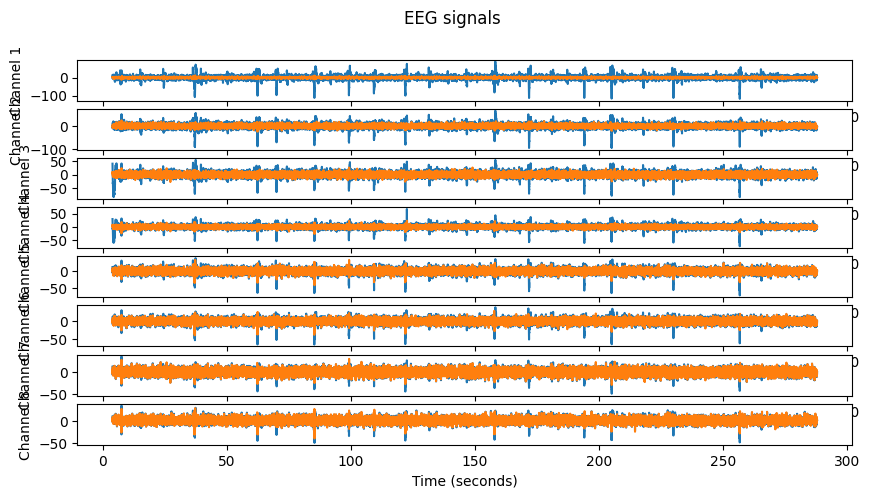

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


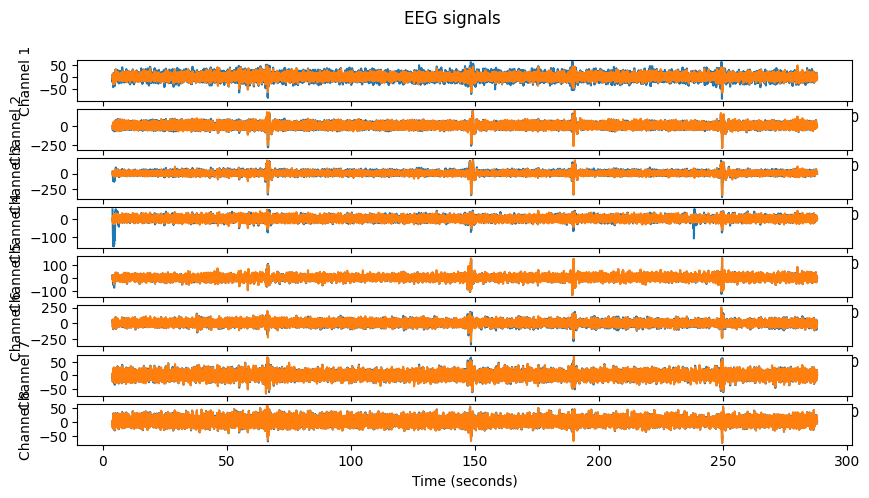

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


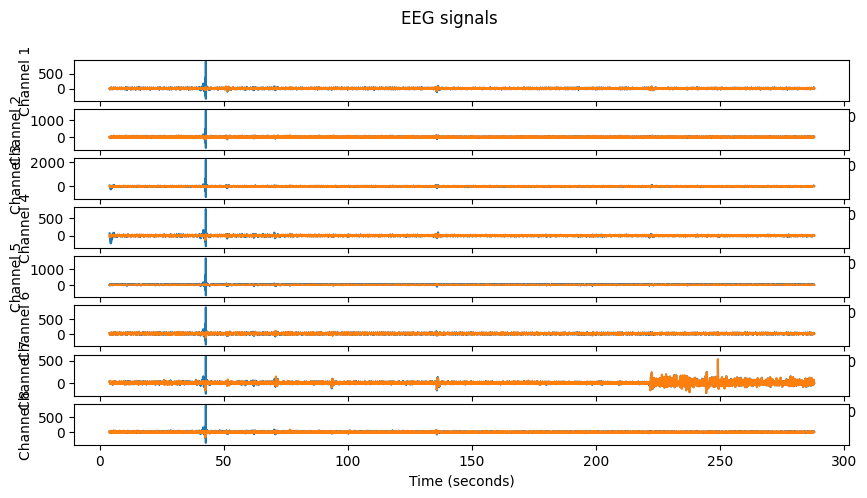

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 4.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


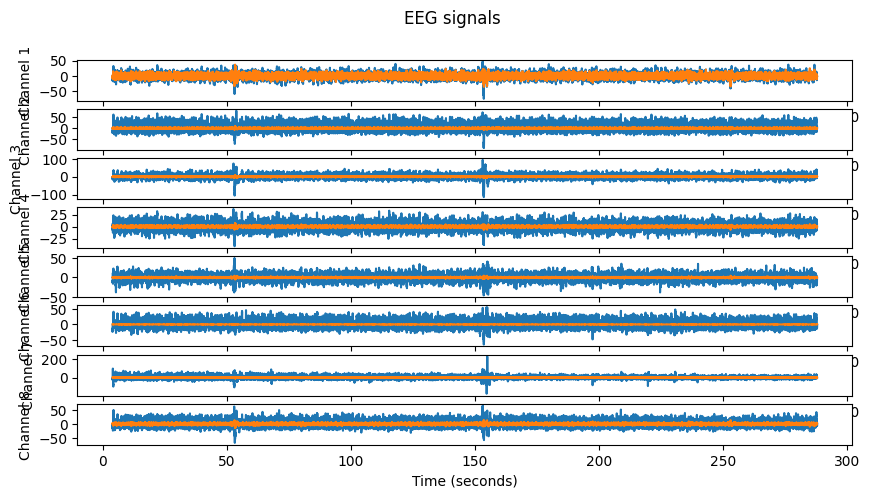

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


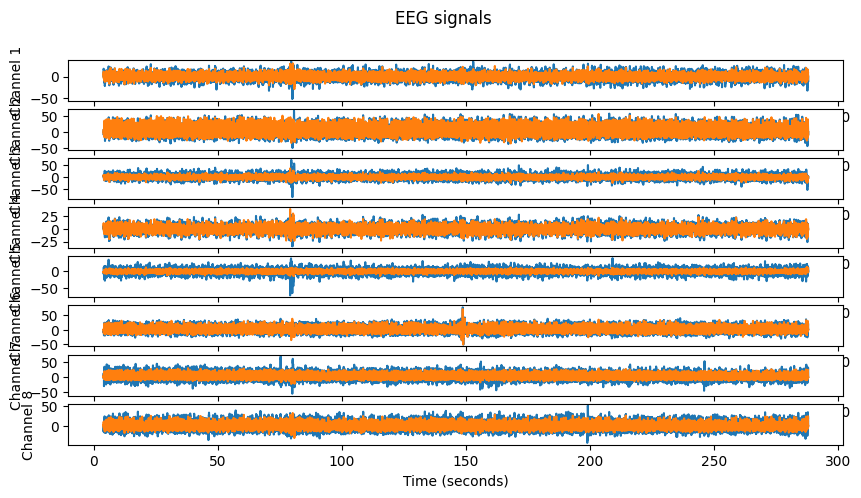

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


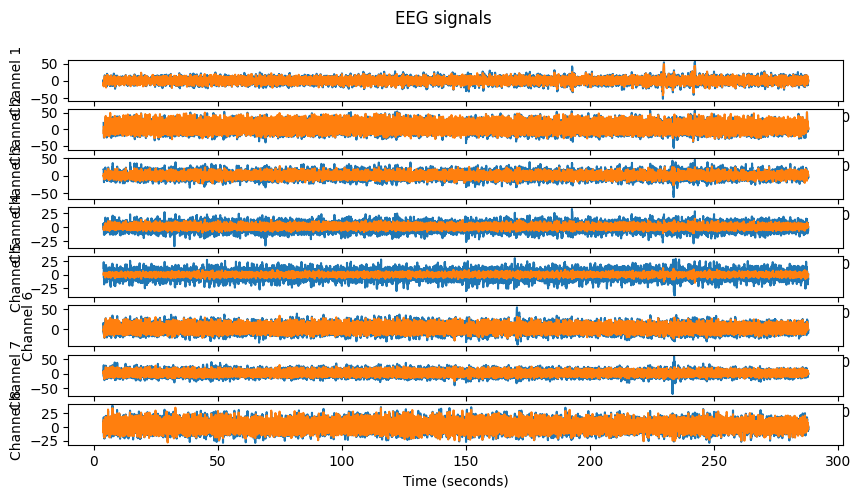

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


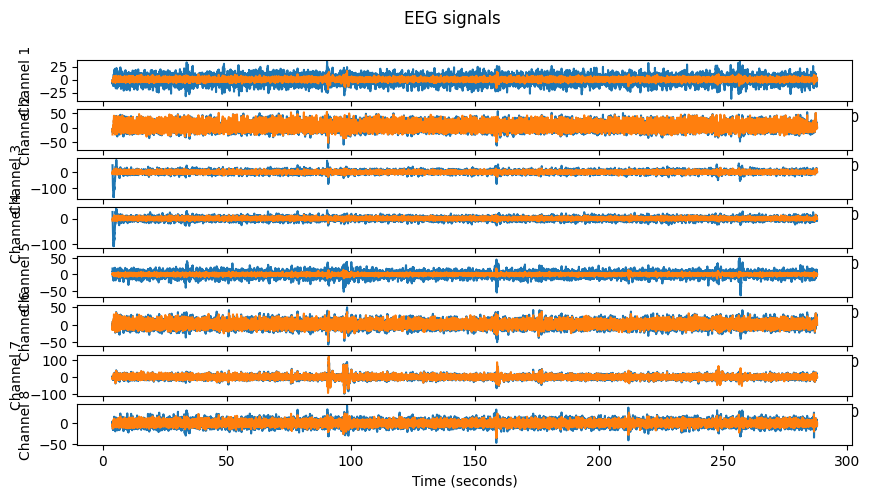

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


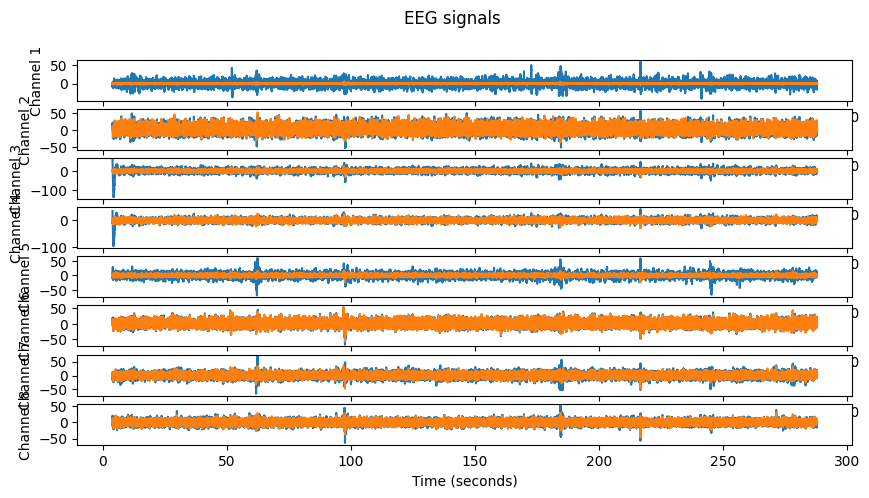

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


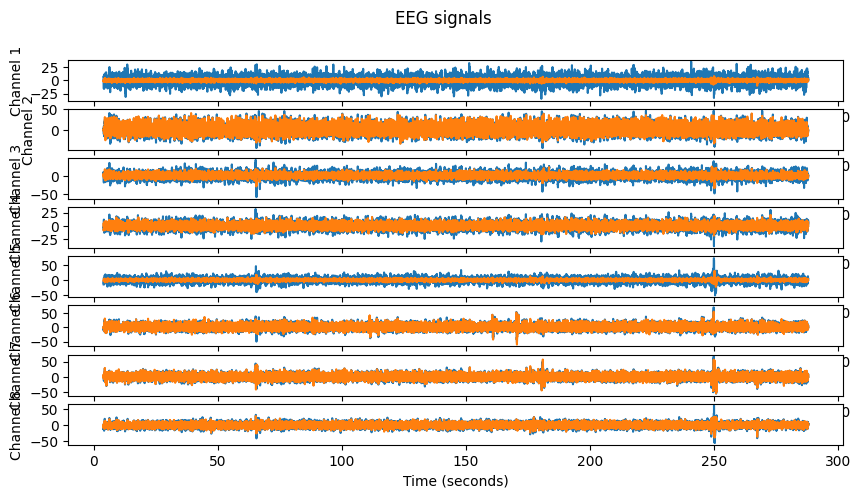

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


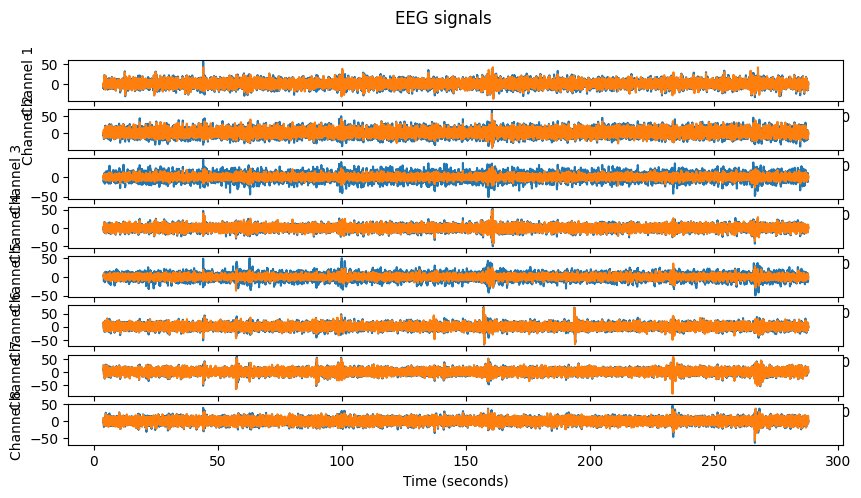

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


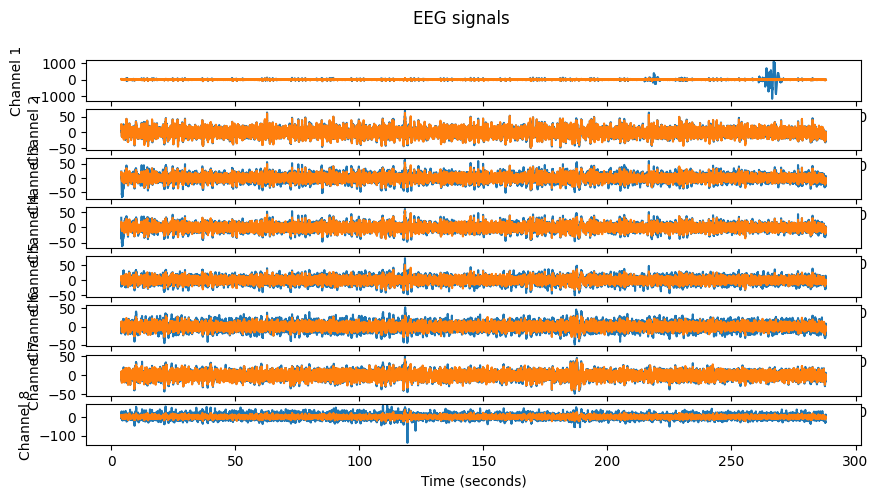

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


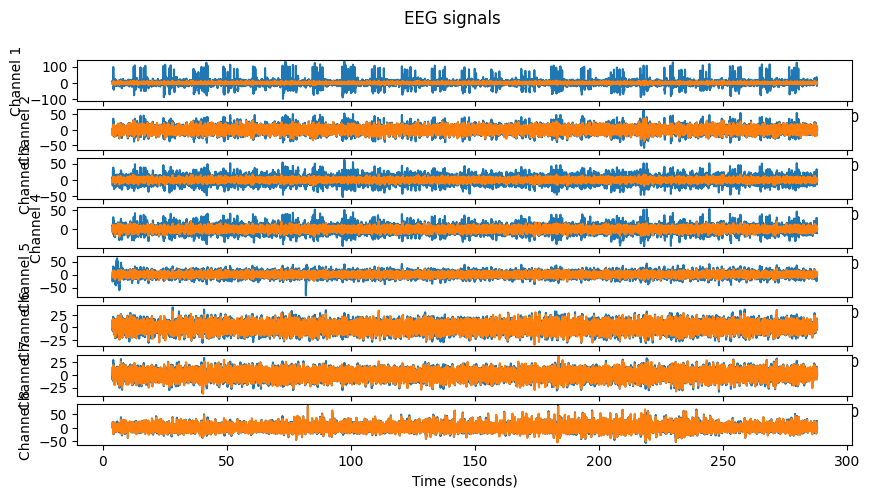

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


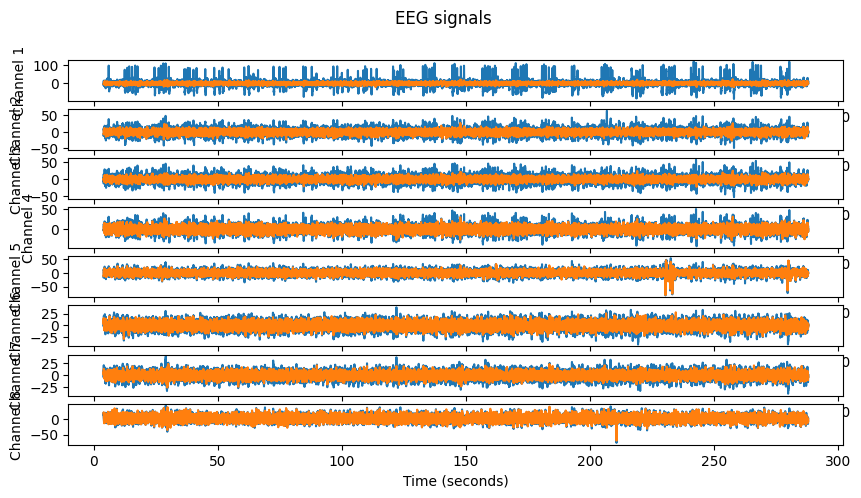

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


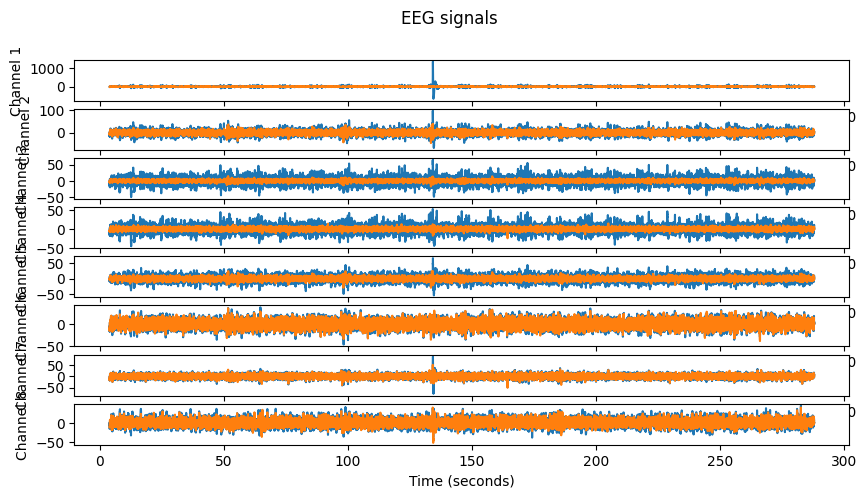

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


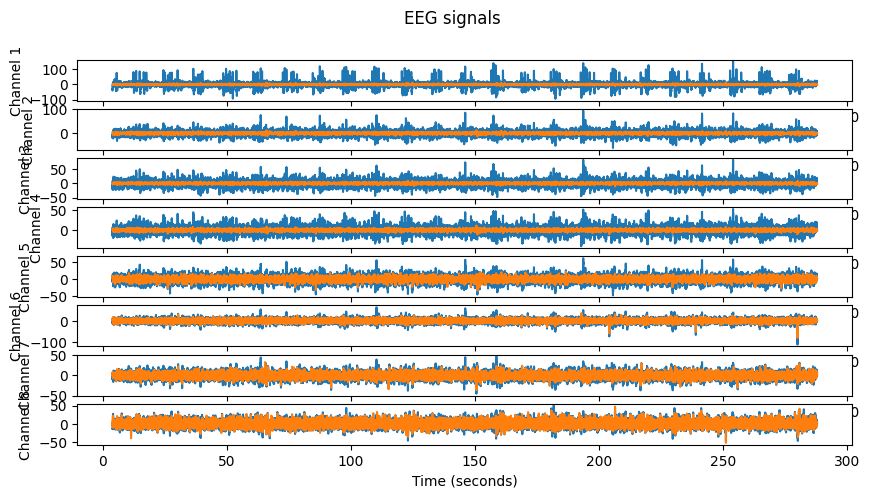

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


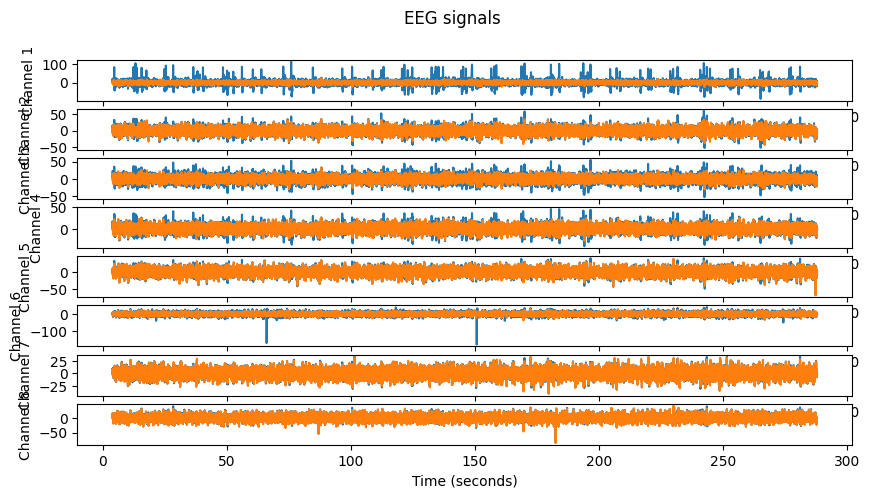

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


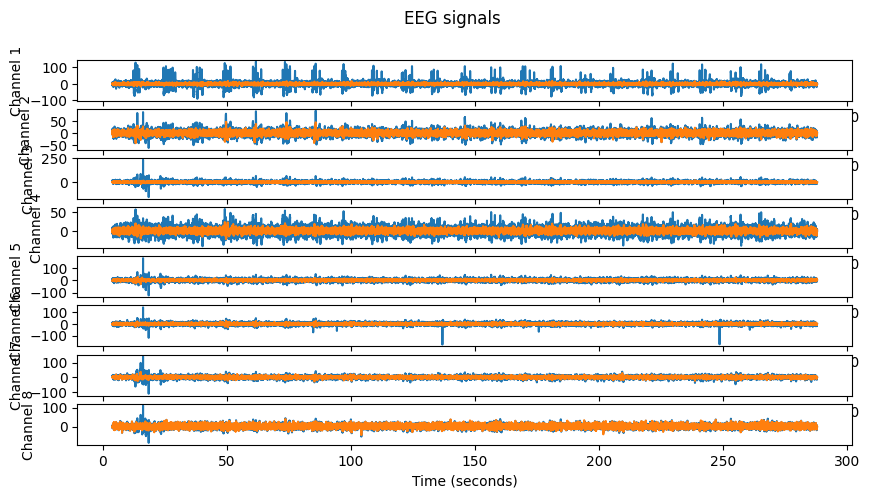

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 4.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


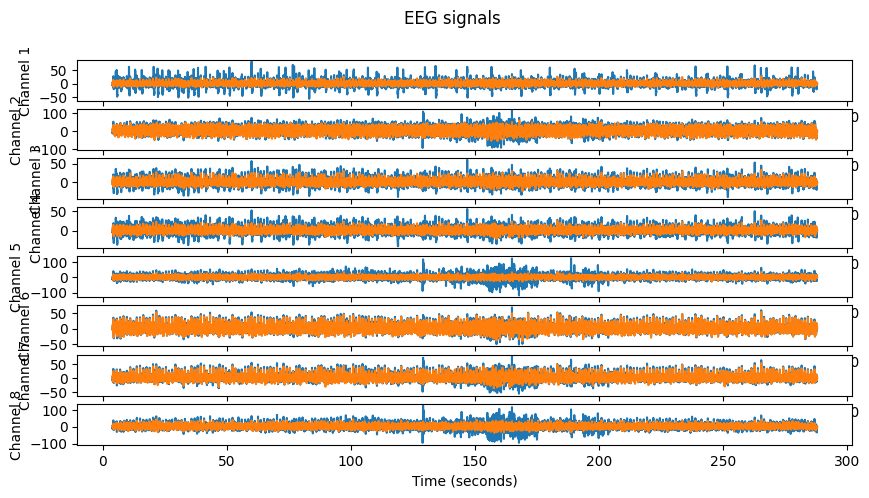

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


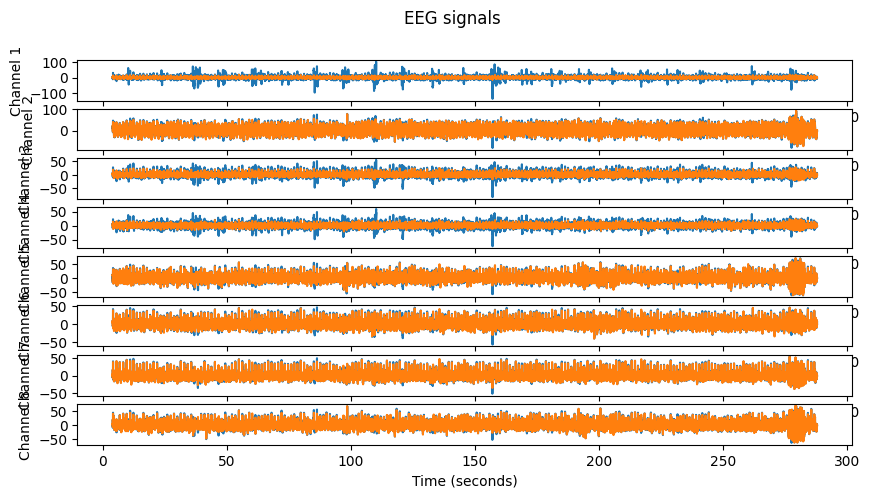

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


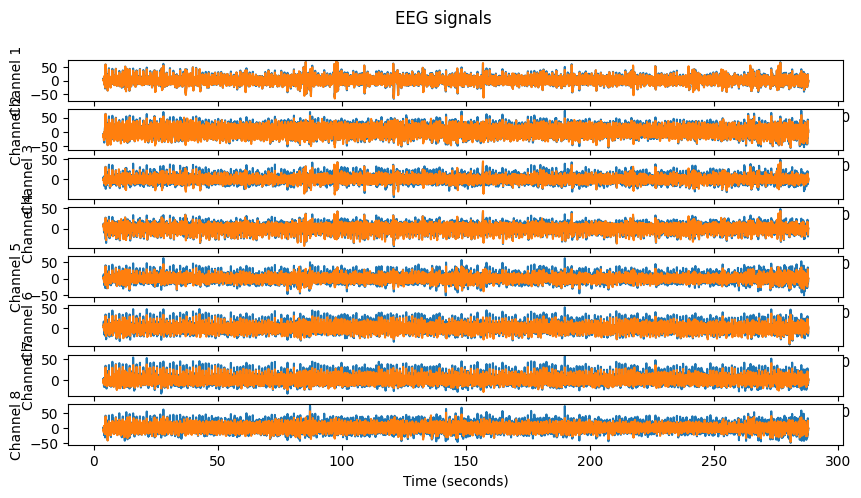

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroi

C:\Users\JackC\AppData\Local\Temp\ipykernel_17396\620839164.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


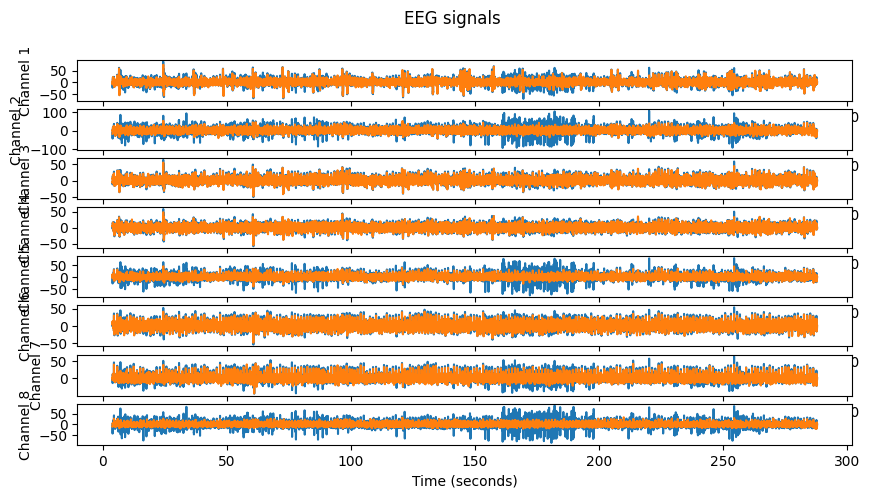

In [9]:
for file in filename_list:
    ICA_filtering(file)